In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [55]:
SEED = 13
tf.random.set_seed(SEED)

In [56]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)):
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [57]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

In [58]:
#from google.colab import drive

#rive.mount('/content/drive')
#path =path = '/content/drive/MyDrive/nmchr_lab/Subjects/inclined/new/right_based/'


In [59]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [60]:
# ---------------------------------------------------- #
#  -> Provide Number of Trainning Subj and Test Subj.  #
#  -> List all the file name per each subj.            #
# ---------------------------------------------------- #

no_subj_train = 4
no_subj_test  = 1

sub1_file = ['TH\TH_4_I_r.xlsx', 'TH\TH_2_I_r.xlsx', 'TH\TH_3_I_r.xlsx']
sub2_file = ['JJ\JJ_4_I_r.xlsx', 'JJ\JJ_6_I_r.xlsx', 'JJ\JJ_7_I_r.xlsx']
sub3_file = ['SD\SD_1_I_r.xls', 'SD\SD_4_I_r.xls', 'SD\SD_2_I_r.xls', 'SD\SD_3_I_r.xls', 'SD\SD_5_I_r.xls']
sub4_file = ['PK\PK_0_I_r.xls', 'PK\PK_5_I_r.xls', 'PK\PK_2_I_r.xls', 'PK\PK_3_I_r.xls']
sub5_file = ['SKS\SKS_0_I_r.xls', 'SKS\SKS_4_I_r.xls', 'SKS\SKS_2_I_r.xls', 'SKS\SKS_3_I_r.xls', 'SKS\SKS_5_I_r.xls']


In [61]:
# ---------------------------------------------------- #
#  -> Concat all Subj into a list                      #
#  -> Randomly shuffle the subj list                   #
# ---------------------------------------------------- #

list1 = [sub1_file, sub2_file, sub3_file, sub4_file, sub5_file]
print("Number of all subject: ", len(list1))

import random
random.shuffle(list1)

Number of all subject:  5


In [62]:
# ---------------------------------------------------- #
#  -> Randomly choose (n) number Subj for testing by   #
#      poping an element from the list                 #
# ---------------------------------------------------- #

test_sub = list1.pop()

print("Test Subj: ", test_sub)

Test Subj:  ['SKS\\SKS_0_I_r.xls', 'SKS\\SKS_4_I_r.xls', 'SKS\\SKS_2_I_r.xls', 'SKS\\SKS_3_I_r.xls', 'SKS\\SKS_5_I_r.xls']


In [63]:
file_list = []

for i in range (len(list1)):
    for j in range(len(list1[i])):
        file_list.append(pd.read_excel(excel_path + list1[i][j], sheet_name='Sheet1'))

In [64]:
random.shuffle(file_list)

all_data = pd.concat(file_list, axis = 0, ignore_index = True)

In [65]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713018 entries, 0 to 713017
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      713018 non-null  float64
 1   l_ph_ank      713018 non-null  float64
 2   l_ph_fo       713018 non-null  float64
 3   r_ph_hip      713018 non-null  float64
 4   r_ph_ank      713018 non-null  float64
 5   r_ph_fo       713018 non-null  float64
 6   n_lgrf        713018 non-null  float64
 7   n_r_grf       713018 non-null  float64
 8   n_lcop        713018 non-null  float64
 9   n_rcop        713018 non-null  float64
 10  perc_new      713018 non-null  float64
 11  st_sw_phase   713018 non-null  int64  
 12  strike_frame  713018 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 70.7 MB


In [66]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table


,l_ph_hip,l_ph_ank,l_ph_fo,r_ph_hip,r_ph_ank,r_ph_fo,n_lgrf,n_r_grf,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.017868,0.611224,0.043116,0.253653,0.755680,0.025736,0.914697,0.036748,0.000091,0.138115,0.000000,1,1
1,0.019354,0.596839,0.043325,0.252341,0.753935,0.035688,0.911922,0.060857,0.000143,0.159908,0.476190,1,2
2,0.020739,0.584172,0.043300,0.250533,0.752362,0.046029,0.903575,0.090786,0.000182,0.182694,0.952381,1,3
3,0.022033,0.573204,0.043038,0.246090,0.750924,0.056553,0.889112,0.126172,0.000209,0.206090,1.428571,1,4
4,0.023243,0.563872,0.042536,0.767538,0.749592,0.067038,0.868265,0.166112,0.000226,0.229617,1.904762,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
709493,0.670652,0.691813,0.209854,0.938383,0.147592,0.768096,0.665881,0.000000,0.090272,-0.000195,97.058824,0,199
709494,0.666237,0.685339,0.202419,0.939329,0.121608,0.763748,0.669678,0.000000,0.091376,-0.000233,97.549020,0,200
709495,0.660828,0.678392,0.191987,0.940358,0.085849,0.760446,0.673737,0.000000,0.092444,-0.000274,98.039216,0,201
709496,0.654074,0.670987,0.176275,0.941378,0.039361,0.757745,0.677892,0.000000,0.093479,-0.000317,98.529412,0,202


In [67]:
drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank"]

In [68]:
source_table = source_table.drop(drop_list, axis = 1)
source_table

,l_ph_hip,l_ph_fo,r_ph_hip,r_ph_fo,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.017868,0.043116,0.253653,0.025736,0.000091,0.138115,0.000000,1,1
1,0.019354,0.043325,0.252341,0.035688,0.000143,0.159908,0.476190,1,2
2,0.020739,0.043300,0.250533,0.046029,0.000182,0.182694,0.952381,1,3
3,0.022033,0.043038,0.246090,0.056553,0.000209,0.206090,1.428571,1,4
4,0.023243,0.042536,0.767538,0.067038,0.000226,0.229617,1.904762,1,5
...,...,...,...,...,...,...,...,...,...
709493,0.670652,0.209854,0.938383,0.768096,0.090272,-0.000195,97.058824,0,199
709494,0.666237,0.202419,0.939329,0.763748,0.091376,-0.000233,97.549020,0,200
709495,0.660828,0.191987,0.940358,0.760446,0.092444,-0.000274,98.039216,0,201
709496,0.654074,0.176275,0.941378,0.757745,0.093479,-0.000317,98.529412,0,202


In [69]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [70]:
data_y = y.values.reshape(-1,2)

In [71]:
type(data_y)

numpy.ndarray

In [72]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25,
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [73]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(532112, 10, 8)
(532112, 2)
(177364, 10, 8)
(177364, 2)


In [74]:
train_x.shape

(532112, 10, 8)

In [75]:
n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(17735, 10, 8)
(17735, 2)


In [76]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [77]:

lr = 0.001
epochs = 30
batch = 128

x=Input(shape=(10, train_x.shape[2]))
n_features=train_x.shape[2]
# RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
LSTM_layer1 = LSTM(64, return_sequences=True)(x)
LSTM_layer2 = LSTM(32, return_sequences=True)(LSTM_layer1)
attn_layer1 = attention()(LSTM_layer2)
rep_layer = L.RepeatVector((10))(attn_layer1)
# attn_layer2 = attention()(rep_layer)
LSTM_layer3 = LSTM(32, return_sequences=True)(rep_layer)
LSTM_layer4 = LSTM(64, return_sequences=True)(LSTM_layer3)
lin_layer = L.TimeDistributed(L.Dense(n_features))(LSTM_layer4)
# tmp_layer = Flatten()(rep_layer)
# lin_layer = L.Dense(2)(tmp_layer)
model=Model(x,lin_layer)
model.summary()
adam = optimizers.Adam(lr)
model.compile(loss='mse', optimizer=adam)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            18688     
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            12416     
                                                                 
 attention (attention)       (None, 32)                42        
                                                                 
 repeat_vector (RepeatVector  (None, 10, 32)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                             

In [78]:
model_history = model.fit( train_x, train_x, epochs=epochs, batch_size=batch,  verbose=1)

Epoch 1/30
4158/4158 [==============================] - 80s 18ms/step - loss: 0.0089
Epoch 2/30
4158/4158 [==============================] - 80s 19ms/step - loss: 0.0027
Epoch 3/30
4158/4158 [==============================] - 101s 24ms/step - loss: 0.0015
Epoch 4/30
4158/4158 [==============================] - 83s 20ms/step - loss: 9.3328e-04
Epoch 5/30
4158/4158 [==============================] - 88s 21ms/step - loss: 6.6370e-04
Epoch 6/30
4158/4158 [==============================] - 88s 21ms/step - loss: 5.0210e-04
Epoch 7/30
4158/4158 [==============================] - 90s 22ms/step - loss: 3.9622e-04
Epoch 8/30
4158/4158 [==============================] - 95s 23ms/step - loss: 3.3196e-04
Epoch 9/30
4158/4158 [==============================] - 91s 22ms/step - loss: 2.8505e-04
Epoch 10/30
4158/4158 [==============================] - 93s 22ms/step - loss: 2.4776e-04
Epoch 11/30
4158/4158 [==============================] - 94s 23ms/step - loss: 2.2084e-04
Epoch 12/30
4158/4158 [=======

In [79]:
encoder = Model(inputs=model.inputs, outputs=model.layers[3].output)
train_encoded = encoder.predict(train_x)
validation_encoded = encoder.predict(validation_x)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

5543/5543 [==============================] - 19s 3ms/step
Encoded time-series shape (532112, 32)
Encoded time-series sample [ 0.03357951 -0.04097783  0.1164674  -0.14629912  0.24036014 -0.08271414
 -0.04313197  0.81028104 -0.0349151  -0.06561087 -0.7548317   0.0156759
 -0.21965647  0.17575069 -0.12388492  0.23742895  0.13296026 -0.2450017
  0.06253985  0.24395259  0.20202038 -0.1712309   0.18408918  0.00919538
  0.14681485  0.11079741  0.02766874 -0.23243117  0.01882275  0.10442038
  0.28970146 -0.06538916]


In [80]:
#model.save(path+"autoen_new_model")

In [81]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [82]:
mlp_model = Sequential()
mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = optimizers.Adam(lr_schedule)

mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,338
Trainable params: 1,338
Non-trainable params: 0
_________________________________________________________________


In [83]:
epochs = 65
# lrate = LearningRateScheduler(step_decay)
monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
train_encoded_reshaped = train_encoded
callback_list = [monitor]
mlp_history = mlp_model.fit(train_encoded_reshaped , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=2)

Epoch 1/65
4158/4158 - 4s - loss: 0.0343 - 4s/epoch - 1ms/step
Epoch 2/65
4158/4158 - 4s - loss: 0.0098 - 4s/epoch - 895us/step
Epoch 3/65
4158/4158 - 4s - loss: 0.0079 - 4s/epoch - 893us/step
Epoch 4/65
4158/4158 - 4s - loss: 0.0069 - 4s/epoch - 874us/step
Epoch 5/65
4158/4158 - 4s - loss: 0.0063 - 4s/epoch - 881us/step
Epoch 6/65
4158/4158 - 4s - loss: 0.0059 - 4s/epoch - 925us/step
Epoch 7/65
4158/4158 - 4s - loss: 0.0056 - 4s/epoch - 865us/step
Epoch 8/65
4158/4158 - 4s - loss: 0.0053 - 4s/epoch - 906us/step
Epoch 9/65
4158/4158 - 4s - loss: 0.0051 - 4s/epoch - 922us/step
Epoch 10/65
4158/4158 - 4s - loss: 0.0050 - 4s/epoch - 865us/step
Epoch 11/65
4158/4158 - 4s - loss: 0.0049 - 4s/epoch - 863us/step
Epoch 12/65
4158/4158 - 4s - loss: 0.0048 - 4s/epoch - 878us/step
Epoch 13/65
4158/4158 - 3s - loss: 0.0047 - 3s/epoch - 729us/step
Epoch 14/65
4158/4158 - 3s - loss: 0.0047 - 3s/epoch - 769us/step
Epoch 15/65
4158/4158 - 3s - loss: 0.0046 - 3s/epoch - 762us/step
Epoch 16/65
4158/4158

In [84]:
val_encoded_reshaped = validation_encoded
trainPredict = mlp_model.predict(train_encoded_reshaped)
testPredict = mlp_model.predict(val_encoded_reshaped)

5543/5543 [==============================] - 5s 951us/step


In [85]:
testPredict.shape

(177364, 2)

In [86]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.06 RMSE
Test Score: 0.06 RMSE


In [87]:
v = X_test[11:]
v.shape

(177364, 8)

In [88]:

x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) :
    pred[iter] = pred[iter] - 100
    
    if abs(pred[iter]) >= 5:
        pred[iter] = 0


  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
     pred[iter] = 100 - pred[iter]
     if abs(pred[iter]) >= 5:
         pred[iter] = 100




  #if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [89]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [90]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    #if (abs(actual[iter] - pred[iter]) <= (i+1)) or (actual[iter]>98) or(actual[iter]<3):
      #correct+=1
      if (abs(actual[iter] - pred[iter]) <= (i+1)):
        correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

114577
177364
Precision  1 :  64.59991881103268
159751
177364
Precision  2 :  90.06957443449629
172242
177364
Precision  3 :  97.1121535373582
175760
177364
Precision  4 :  99.09564511400283
176842
177364
Precision  5 :  99.70568999345977


In [91]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)



Predicting Percentage RMSE:  1.2732067750982983


In [92]:
rmse = 0
length = len(actual)
for i in range(len(actual)):

    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

177364
177364
1.2732067750983014


117195
177364


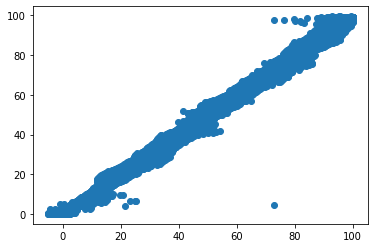

In [93]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<2 or actual[iter]>98:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

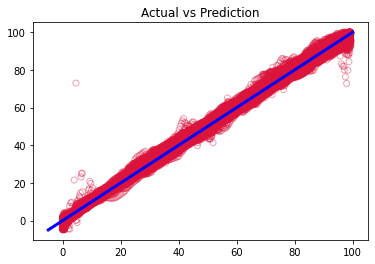

In [94]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

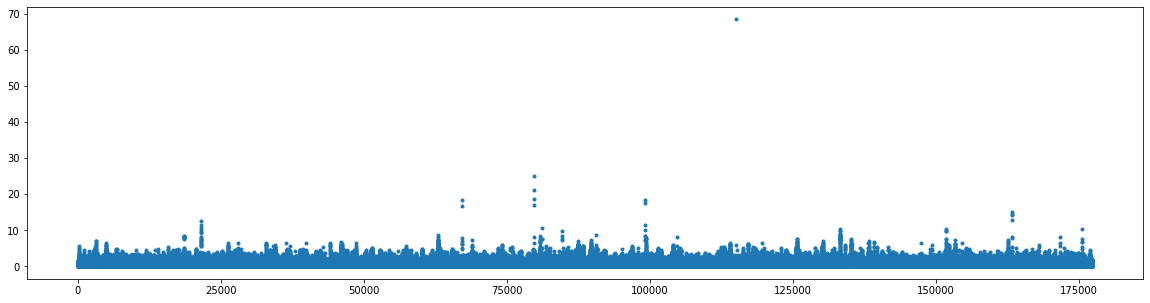

In [95]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual-pred)

plt.plot(dif,'.')

In [96]:
for i in range(len(pred)):
    if (abs(actual[i]-pred[i]) > 50):
        print(i)

115061


In [97]:
print('Predict: ', pred[33642])
print('Actual: ', actual[33642])

Predict:  [26.57805893]
Actual:  [25.]


In [98]:
x_test[33642][:]

array([ 2.70634804e-02,  9.83891144e-01,  9.45832547e-01,  8.80703034e-01,
       -1.82715011e-05,  2.50802465e-01,  1.00000000e+00,  6.20000000e+01])

***TESTING ON OTHER SUBJECT***

In [154]:
test_file_list = []

for i in range(len(test_sub)):
    test_file_list.append(pd.read_excel(excel_path + test_sub[i], sheet_name='Sheet1'))

In [155]:
## if there are multiple subject to test:
# random.shuffle(test_file_list)

all_test = pd.concat(test_file_list, axis = 0, ignore_index = True)

In [156]:
all_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295263 entries, 0 to 295262
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      295263 non-null  float64
 1   l_ph_ank      295263 non-null  float64
 2   l_ph_fo       295263 non-null  float64
 3   r_ph_hip      295263 non-null  float64
 4   r_ph_ank      295263 non-null  float64
 5   r_ph_fo       295263 non-null  float64
 6   n_lgrf        295263 non-null  float64
 7   n_r_grf       295263 non-null  float64
 8   n_lcop        295263 non-null  float64
 9   n_rcop        295263 non-null  float64
 10  perc_new      295263 non-null  float64
 11  st_sw_phase   295263 non-null  int64  
 12  strike_frame  295263 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 29.3 MB


In [157]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_test) - 1):
    if (all_test['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_test.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
test_table = pd.concat(cycle_list, axis=0, ignore_index=True)

test_table

,l_ph_hip,l_ph_ank,l_ph_fo,r_ph_hip,r_ph_ank,r_ph_fo,n_lgrf,n_r_grf,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.638359,0.738215,0.771401,0.911670,0.884725,0.701423,0.844324,0.038365,0.163448,0.010740,0.000000,1,1
1,0.620058,0.737532,0.768151,0.906039,0.864757,0.700908,0.830976,0.066548,0.162116,0.012832,0.446429,1,2
2,0.596447,0.736816,0.765283,0.900631,0.849643,0.699953,0.814171,0.102072,0.160502,0.015089,0.892857,1,3
3,0.566294,0.736063,0.762712,0.895437,0.838038,0.698556,0.793422,0.144811,0.158582,0.017490,1.339286,1,4
4,0.529439,0.735270,0.760373,0.890445,0.828978,0.696702,0.768448,0.194128,0.156332,0.020011,1.785714,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293675,0.659152,0.742170,0.813517,0.003671,0.009516,0.666058,0.961016,0.000000,0.163211,0.001606,97.196262,1,209
293676,0.648888,0.741435,0.802587,0.997556,0.971342,0.669474,0.959978,0.000000,0.163563,0.002583,97.663551,1,210
293677,0.636367,0.740698,0.794134,0.991333,0.937262,0.671841,0.956459,0.000000,0.163786,0.003730,98.130841,1,211
293678,0.620895,0.739953,0.787407,0.985027,0.909164,0.673253,0.950116,0.000000,0.163856,0.005059,98.598131,1,212


In [158]:
test_table = test_table.drop(drop_list, axis = 1)
test_table

,l_ph_hip,l_ph_fo,r_ph_hip,r_ph_fo,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.638359,0.771401,0.911670,0.701423,0.163448,0.010740,0.000000,1,1
1,0.620058,0.768151,0.906039,0.700908,0.162116,0.012832,0.446429,1,2
2,0.596447,0.765283,0.900631,0.699953,0.160502,0.015089,0.892857,1,3
3,0.566294,0.762712,0.895437,0.698556,0.158582,0.017490,1.339286,1,4
4,0.529439,0.760373,0.890445,0.696702,0.156332,0.020011,1.785714,1,5
...,...,...,...,...,...,...,...,...,...
293675,0.659152,0.813517,0.003671,0.666058,0.163211,0.001606,97.196262,1,209
293676,0.648888,0.802587,0.997556,0.669474,0.163563,0.002583,97.663551,1,210
293677,0.636367,0.794134,0.991333,0.671841,0.163786,0.003730,98.130841,1,211
293678,0.620895,0.787407,0.985027,0.673253,0.163856,0.005059,98.598131,1,212


In [159]:
x_test = test_table
x_test = x_test.drop(['perc_new'], axis=1)
scaler2 = MinMaxScaler()
x_test_scaled = scaler2.fit_transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled)

encode_gait_percentage(test_table, 'perc_new')
y_test = source_table[["X","Y"]]
y_test

data_x_test = x_test_scaled


In [160]:
#data_y_test = y_test.values.reshape(-1, 2)
data_y_test = y_test.values

In [161]:
test_x, test_y = convert_data(data_x_test, data_y_test, look_back, fore_cast)

In [162]:
check_point = data_x_test[11:]
check_point.shape

(293669, 8)

In [163]:
print(test_x.shape)

(293669, 10, 8)


In [164]:
test_encoded = encoder.predict(test_x)

   1/9178 [..............................] - ETA: 5:02

9178/9178 [==============================] - 37s 4ms/step


In [165]:
print('Encoded time-series shape', test_encoded.shape)
print('Encoded time-series sample', test_encoded[0])

Encoded time-series shape (293669, 32)
Encoded time-series sample [-0.21838483 -0.19951108  0.1406983  -0.0618284   0.3190807   0.11974008
  0.1843057   0.81619716 -0.03637911 -0.13963985 -0.613057   -0.23442885
 -0.1939916  -0.08239627 -0.08661512  0.16815525 -0.07348612  0.22166923
  0.17101583  0.24784024  0.14950073 -0.14180306  0.10987338  0.07469337
 -0.11589661 -0.24705464  0.23963225  0.2893739  -0.0331614   0.10528422
  0.3657588  -0.04675761]


In [166]:
test_encoded_reshape = test_encoded

crossPredict = mlp_model.predict(test_encoded_reshape)

  46/9178 [..............................] - ETA: 10s 

9178/9178 [==============================] - 8s 916us/step


In [167]:
crossPredict.shape

(293669, 2)

In [168]:
crossScore = np.sqrt(mean_squared_error(test_y, crossPredict))
print('Cross Subject Score: %.2f RMSE' % (crossScore))

Cross Subject Score: 0.92 RMSE


In [169]:

check_point_test = scaler.inverse_transform(check_point)

predict = np.zeros((len(crossPredict),1))

for iter in range(len(crossPredict)):
  x = crossPredict[iter][0]
  y = crossPredict[iter][1]
  predict[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


  if ((predict[iter] >= 80) & (check_point_test[iter][-1] <= 20)) :
    predict[iter] = predict[iter] - 100
    
    if abs(predict[iter]) >= 5:
        predict[iter] = 0


  if ((predict[iter] <= 20) & (check_point_test[iter][-1] >= 150)):
     predict[iter] = 100 - predict[iter]
     if abs(predict[iter]) >= 5:
         predict[iter] = 100

In [170]:
actual2 = np.zeros((len(test_y),1))

for iter in range(len(test_y)):
  x = test_y[iter][0]
  y = test_y[iter][1]
  actual2[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [171]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual2)):
    #if (abs(actual[iter] - pred[iter]) <= (i+1)) or (actual[iter]>98) or(actual[iter]<3):
      #correct+=1
      if (abs(actual2[iter] - predict[iter]) <= (i+1)):
        correct+=1

  print(correct)
  print(len(actual2))

  print("Precision ", i+1, ": ", correct * 100/len(actual2))

5941
293669
Precision  1 :  2.023025923744079
11714
293669
Precision  2 :  3.988844583527713
17674
293669
Precision  3 :  6.018340376410176
23799
293669
Precision  4 :  8.104021874968076
30110
293669
Precision  5 :  10.25303998719647


In [172]:
perc_rmse_cross = np.sqrt(mean_squared_error(actual2, predict))
print("Predicting Percentage RMSE: ", perc_rmse_cross)

Predicting Percentage RMSE:  36.9051214766643


In [173]:
rmse = 0
length = len(actual2)
for i in range(len(actual2)):

    rmse = rmse + pow(predict[i] - actual2[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual2))
print(rmse)

293669
293669
36.905121476664824


Text(0.5, 1.0, 'Actual vs Prediction')

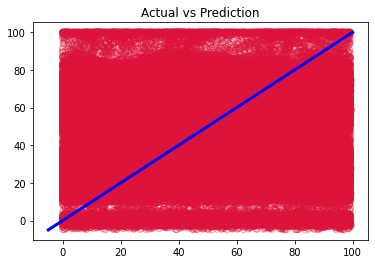

In [174]:
plt.scatter(actual2, predict, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(predict), max(actual2))
p2 = min(min(predict), min(actual2))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

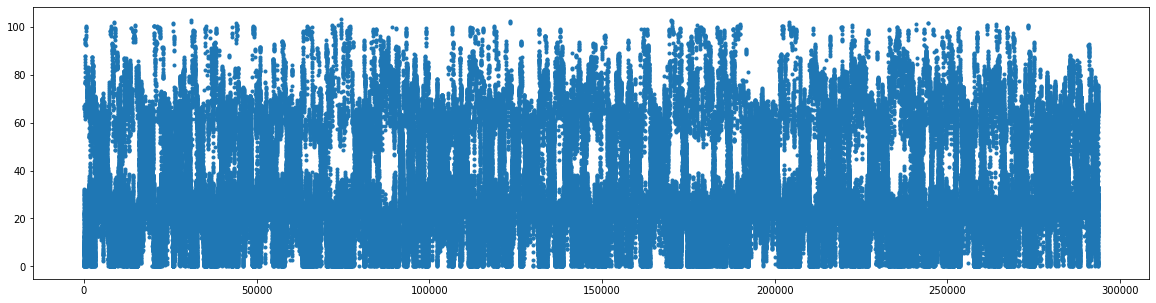

In [175]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual2-predict)

plt.plot(dif,'.')